In [1]:
#chapter 10 -함수형 API
# 각 층의 입력과 출력 관계를 함수 처럼 정의, Model()에사 전체 모델의 입력층과 출력층의 인수를 설정하여 모델을 생성
#43_01 - 모양을 변경하는 함수
import tensorflow as tf
import numpy as np

#1: 
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

#2: create 2D input data
A = np.array([[1, 2, 3, 4],
              [5, 6, 7, 8 ]],dtype='float32')
A = A.reshape(1, 2, 4, 1)  # (batch, rows, cols, channels)
print("A = ", A)
#3: build a model
x = tf.keras.layers.Input(shape=A.shape[1:])
y = tf.keras.layers.Reshape([4, 2, 1])(x)  # (1, 4, 2, 1) > (1,2,3,4)가 한개 
print("y = ", y)
z = tf.keras.layers.Permute([2, 1, 3])(x)

model = tf.keras.Model(inputs=x, outputs= [y, z])
model.summary()

#4: apply A to model
##output = model(A)    # Tensor output
output = model.predict(A)  # numpy output
print("A[0,:,:,0]=",A[0,:,:,0])
print("output[0]=", output[0][0,:,:,0])  # y
print("output[1]", output[1][0,:,:,0])   # z


A =  [[[[1.]
   [2.]
   [3.]
   [4.]]

  [[5.]
   [6.]
   [7.]
   [8.]]]]
y =  KerasTensor(type_spec=TensorSpec(shape=(None, 4, 2, 1), dtype=tf.float32, name=None), name='reshape/Reshape:0', description="created by layer 'reshape'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 4, 1)]    0           []                               
                                                                                                  
 reshape (Reshape)              (None, 4, 2, 1)      0           ['input_1[0][0]']                
                                                                                                  
 permute (Permute)              (None, 4, 2, 1)      0           ['input_1[0][0]']                
                                                           

In [2]:
#43_02
import tensorflow as tf
import numpy as np

#1: 
##gpus = tf.config.experimental.list_physical_devices('GPU')
##tf.config.experimental.set_memory_growth(gpus[0], True)

#2: create 2D input data
A = np.array([[1, 2, 3, 4],
              [5, 6, 7, 8 ]],dtype='float32')
A = A.reshape(1, 2, 4, 1)  # (batch, rows, cols, channels)

#3: build a model
x = tf.keras.layers.Input(shape=A.shape[1:])
y = tf.keras.layers.UpSampling2D()(x) # size = (2,2), [None, 4, 8, 1] - 가로, 세로 2배로 늘리기

u = tf.keras.layers.Reshape([8, 1])(x)
z = tf.keras.layers.UpSampling1D()(u) # size = 2, [None, 16, 1] - output[1]의 결과를 확인

model = tf.keras.Model(inputs=x, outputs= [y, z])
model.summary()

#4: apply A to model
##output = model(A)      # Tensor output
output = model.predict(A) # numpy output
print("A[0,:,:,0]=",A[0,:,:,0])
print("output[0]=", output[0][0,:,:,0])  # y
print("output[1]", output[1][0,:,0])     # z


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2, 4, 1)]    0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 8, 1)         0           ['input_2[0][0]']                
                                                                                                  
 up_sampling2d (UpSampling2D)   (None, 4, 8, 1)      0           ['input_2[0][0]']                
                                                                                                  
 up_sampling1d (UpSampling1D)   (None, 16, 1)        0           ['reshape_1[0][0]']              
                                                                                            

In [3]:
#43_03 - 병합 연산
import tensorflow as tf
import numpy as np

#1: 
#gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)

#2: 1D input data: A, B
A = np.array([1, 2, 3, 4, 5]).astype('float32')
B = np.array([1, 2, 3, 4, 5, 6, 7, 8]).astype('float32')
A = np.reshape(A, (1, -1, 1)) # (batch, steps, channels) (1,5,1)
B = np.reshape(B, (1, -1, 1)) # (batch, steps, channels)  (1,8,1)

#3: build a model
input_x = tf.keras.layers.Input(shape=A.shape[1:])
input_y = tf.keras.layers.Input(shape=B.shape[1:])
 
x = tf.keras.layers.MaxPool1D()(input_x)
y = tf.keras.layers.MaxPool1D()(input_y) 

pad = y.shape[1] - x.shape[1] # 2 - 패딩 길이 차이를 pad가 저장
x = tf.keras.layers.ZeroPadding1D(padding=(0, pad))(x) # x의 오른쪽을 제로 패딩

out2 = tf.keras.layers.Add()([x, y]) #357페이지 그림 43.3
##out2 = tf.keras.layers.Subtract()([x, y])
##out2 = tf.keras.layers.Multiply()([x, y])
##out2 = tf.keras.layers.Minimum()([x, y])
##out2 = tf.keras.layers.Maximum()([x, y])
##out2 = tf.keras.layers.Average()([x, y])
out3 = tf.keras.layers.Concatenate()([x, y]) # 그림 43.4
out4 = tf.keras.layers.Dot(axes=[1,1])([x, y]) # inner product 
out5 = tf.keras.layers.Dot(axes=-1)([x, y])    # outer product - 그림 43.5

out_list = [x, y, out2, out3, out4, out5]
model = tf.keras.Model(inputs=[input_x, input_y], outputs= out_list)
##model.summary()
print("model.output_shape=", model.output_shape)

#4: apply [A, B] to model
##output = model([A, B])      # Tensor output
output = model.predict([A, B]) # numpy output - [A,B]를 입력
for i in range(len(output)):
    print("output[{}]={}".format(i, output[i])) # output[i]를 출력 결과 확인


model.output_shape= [(None, 4, 1), (None, 4, 1), (None, 4, 1), (None, 4, 2), (None, 1, 1), (None, 4, 4)]
1/1 [==============================] - 4s 4s/step
output[0]=[[[2.]
  [4.]
  [0.]
  [0.]]]
output[1]=[[[2.]
  [4.]
  [6.]
  [8.]]]
output[2]=[[[4.]
  [8.]
  [6.]
  [8.]]]
output[3]=[[[2. 2.]
  [4. 4.]
  [0. 6.]
  [0. 8.]]]
output[4]=[[[20.]]]
output[5]=[[[ 4.  8. 12. 16.]
  [ 8. 16. 24. 32.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]]


In [4]:
#43_04 - 2D 병합 연산 
import tensorflow as tf
import numpy as np

#1: 
#gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)

#2: 2D input data: A, B, C
A = np.array([[1, 2],
              [3, 4]],dtype='float32')
A = A.reshape(-1, 2, 2, 1) # (batch, rows, cols, channels)

B = np.array([[5, 6],
              [7, 8]],dtype='float32')
B = B.reshape(-1, 2, 2, 1) # (batch, rows, cols, channels)

C = np.array([1, 2, 3]).astype('float32')
C = C.reshape(-1, 3, 1, 1) # (batch, rows, cols, channels)
 
#3: build a model
x = tf.keras.layers.Input(shape=A.shape[1:]) # shape=(2, 2, 1)
y = tf.keras.layers.Input(shape=B.shape[1:]) # shape=(2, 2, 1)
z = tf.keras.layers.Input(shape=C.shape[1:]) # shape=(3, 1, 1) 
out3 = tf.keras.layers.Add()([x, y]) # 360페이지 그림 43.6
##out3 = tf.keras.layers.Subtract()([x, y])
##out3 = tf.keras.layers.Multiply()([x, y])
##out3 = tf.keras.layers.Minimum()([x, y])
##out3 = tf.keras.layers.Maximum()([x, y])
##out3 = tf.keras.layers.Average()([x, y])
out4 = tf.keras.layers.Concatenate()([x, y]) # out4.shape = (1,2,2,2)
out5 = tf.keras.layers.Dot(axes= -1)([x, y])   # outer product - 그림 43.7
out6 = tf.keras.layers.Dot(axes= -1)([x, z])   # outer product - 그림 43.8
out_list = [x, y, z, out3, out4, out5, out6]
model = tf.keras.Model(inputs=[x, y, z], outputs= out_list)
##model.summary()
print("model.output_shape=", model.output_shape)

#4: apply [A, B, C] to model
##output = model([A, B, C])       # Tensor output
output = model.predict([A, B, C]) # numpy output
for i in range(len(output)):
    print("output[{}]={}".format(i, output[i]))   # output[i] 결과를 확인


model.output_shape= [(None, 2, 2, 1), (None, 2, 2, 1), (None, 3, 1, 1), (None, 2, 2, 1), (None, 2, 2, 2), (None, 2, 2, 2, 2), (None, 2, 2, 3, 1)]
1/1 [==============================] - 0s 141ms/step
output[0]=[[[[1.]
   [2.]]

  [[3.]
   [4.]]]]
output[1]=[[[[5.]
   [6.]]

  [[7.]
   [8.]]]]
output[2]=[[[[1.]]

  [[2.]]

  [[3.]]]]
output[3]=[[[[ 6.]
   [ 8.]]

  [[10.]
   [12.]]]]
output[4]=[[[[1. 5.]
   [2. 6.]]

  [[3. 7.]
   [4. 8.]]]]
output[5]=[[[[[ 5.  6.]
    [ 7.  8.]]

   [[10. 12.]
    [14. 16.]]]


  [[[15. 18.]
    [21. 24.]]

   [[20. 24.]
    [28. 32.]]]]]
output[6]=[[[[[ 1.]
    [ 2.]
    [ 3.]]

   [[ 2.]
    [ 4.]
    [ 6.]]]


  [[[ 3.]
    [ 6.]
    [ 9.]]

   [[ 4.]
    [ 8.]
    [12.]]]]]


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 and (Dense)                    (None, 1)            3           ['input_8[0][0]']                
                                                                                                  
 or (Dense)                     (None, 1)            3           ['input_9[0][0]']                
                                                                                            

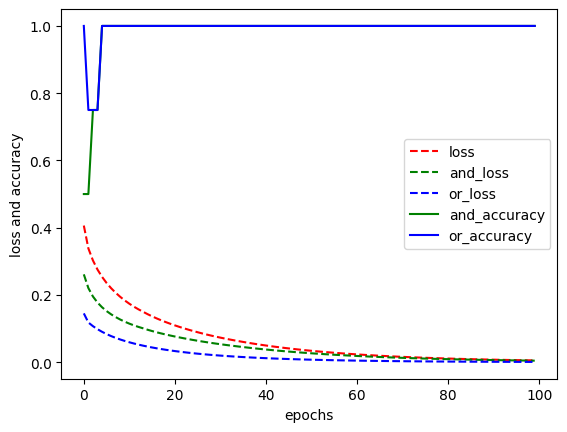

In [5]:
#43_05 - AND, OR (1 Dense)
import tensorflow as tf
from tensorflow.keras.layers     import Input, Dense
import numpy as np
import matplotlib.pyplot as plt

#1: ref [step37_01], [그림 2.9]
##gpus = tf.config.experimental.list_physical_devices('GPU')
##tf.config.experimental.set_memory_growth(gpus[0], True)

#2
X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]], dtype = np.float32)
y_and = np.array([[0],[0], [0],[1]], dtype = np.float32)    # AND
y_or = np.array([[0],[1],[1],[1]], dtype = np.float32)      # OR

#3: build a model
x_and = Input(shape = (2,))
out_and = Dense(units = 1, activation = 'sigmoid', name = 'and')(x_and) # AND 연산

x_or = Input(shape = (2, ))
out_or = Dense(units = 1, activation = 'sigmoid', name = 'or')(x_or) # OR 연산

model = tf.keras.Model(inputs = [x_and, x_or], outputs = [out_and, out_or])
model.summary()

#4: train and evaluate
opt = tf.keras.optimizers.RMSprop(learning_rate = 0.1)
model.compile(optimizer = opt, loss = 'mse', metrics = ['accuracy'])
ret = model.fit(x = [X, X], y = [y_and, y_or],
               epochs = 100, batch_size = 4, verbose = 0)    # silent - 반복 학습
test = model.evaluate(x = [X, X], y = [y_and, y_or], verbose = 0) # 모델 평가
print('total loss = ', test[0])        # test[1] + test[2] # 전체 손실
print('AND: loss={}, acc={}'.format(test[1], test[3])) # AND 손실 정확도
print('OR: loss={}, acc={}'.format(test[2], test[4])) # OR 손실 정확도

#5: draw graph
plt.plot(ret.history['loss'],     'r--',  label='loss')
plt.plot(ret.history['and_loss'], 'g--', label='and_loss')
plt.plot(ret.history['or_loss'],  'b--', label='or_loss')
plt.plot(ret.history['and_accuracy'], 'g-', label='and_accuracy')
plt.plot(ret.history['or_accuracy'],  'b-', label='or_accuracy')
plt.xlabel('epochs')
plt.ylabel('loss and accuracy')
plt.legend(loc = 'best')
plt.show()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 2)]          0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 2)]          0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 2)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 2)            6           ['input_10[0][0]']               
                                                                                            

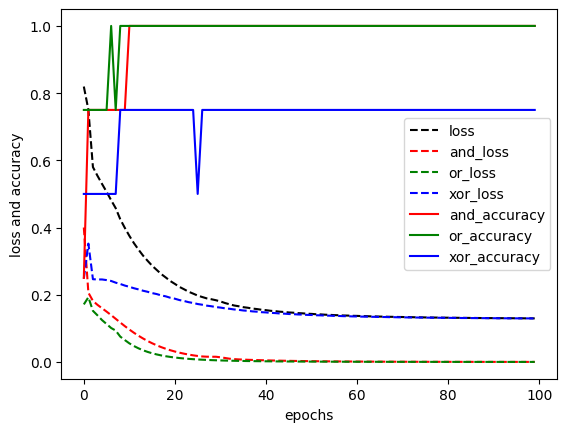

In [6]:
#43_06 - AND, OR, XOR (2 Deense)
import tensorflow as tf
from tensorflow.keras.layers     import Input, Dense
import numpy as np
import matplotlib.pyplot as plt

#1: 
##gpus = tf.config.experimental.list_physical_devices('GPU')
##tf.config.experimental.set_memory_growth(gpus[0], True)

#2
X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]], dtype = np.float32)
y_and = np.array([[0],[0], [0],[1]], dtype = np.float32) # AND
y_or  = np.array([[0],[1],[1],[1]], dtype = np.float32)  # OR
y_xor = np.array([[0],[1],[1],[0]], dtype = np.float32)  # XOR

y_and = tf.keras.utils.to_categorical(y_and)
y_or  = tf.keras.utils.to_categorical(y_or)
y_xor = tf.keras.utils.to_categorical(y_xor)

#3: build a model
x_and  = Input(shape=(2,))
x      = Dense(units=2, activation='sigmoid')(x_and)
out_and= Dense(units=2, activation='softmax', name='and')(x)

x_or   = Input(shape=(2,))
x      = Dense(units=2, activation='sigmoid')(x_or)
out_or = Dense(units=2, activation='softmax', name='or')(x)

x_xor  = Input(shape=(2,))
x      = Dense(units=2, activation='sigmoid')(x_xor)
out_xor= Dense(units=2, activation='softmax', name='xor')(x) 
#모델 생성
model  = tf.keras.Model(inputs = [x_and,   x_or,  x_xor],
                        outputs= [out_and, out_or,  out_xor])
model.summary()

#4: train and evaluate
opt = tf.keras.optimizers.RMSprop(learning_rate=0.1)
model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])
ret = model.fit(x=[X, X, X], y=[y_and, y_or, y_xor],
                epochs=100, batch_size=4, verbose=0)

test = model.evaluate(x=[X, X, X], y=[y_and, y_or, y_xor], verbose=0)
print('total loss = ', test[0]) # test[1] + test[2] + test[3]
print('AND: loss={}, acc={}'.format(test[1], test[4]))
print('OR:  loss={}, acc={}'.format(test[2],  test[5]))
print('XOR: loss={}, acc={}'.format(test[3],  test[6]))

#5: draw graph
plt.plot(ret.history['loss'],    'k--', label='loss')
plt.plot(ret.history['and_loss'],'r--', label='and_loss')
plt.plot(ret.history['or_loss'], 'g--', label='or_loss')
plt.plot(ret.history['xor_loss'],'b--', label='xor_loss')

plt.plot(ret.history['and_accuracy'], 'r-', label='and_accuracy')
plt.plot(ret.history['or_accuracy'],  'g-', label='or_accuracy')
plt.plot(ret.history['xor_accuracy'], 'b-', label='xor_accuracy')
plt.xlabel('epochs')
plt.ylabel('loss and accuracy')
plt.legend(loc='best')
plt.show()


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 576, 768, 3)]     0         
                                                                 
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 47ms/step


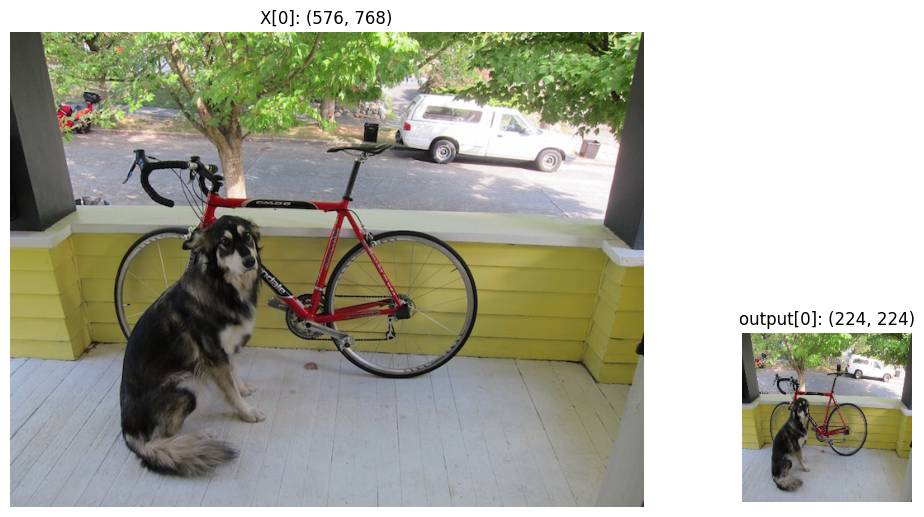

In [11]:
#43_07 - 영상 크기 조정
import tensorflow as tf
from tensorflow.keras.layers     import Input, Lambda
from tensorflow.keras.preprocessing import image # pip install pillow
import numpy as np
import matplotlib.pyplot as plt

#1: 
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

#2: input an image
img_path = '../data/dog1.jpg'    # './data/elephant.jpg' > image를 못 갖고 오면 content 폴더에 복사
img = image.load_img(img_path) #, target_size=(224, 224))
X = image.img_to_array(img)
X = np.expand_dims(X, axis=0)  # (1, img.height,img.width, 3) 4차원으로 확장 

#3: resize_layer
inputs = Input(shape=X.shape[1:])
# 람다식은 keras layer 형식으로 통일 시켜 준다: 외부 데이터를 받아 변경하거나 다른 텐서플로우의 출력을 전달
resize_layer = Lambda(lambda x: tf.image.resize(x,(224, 224)))(inputs)
model  = tf.keras.Model(inputs = inputs, outputs= resize_layer)# 모델 생성 
model.summary()

#4: predict an image
output = model.predict(X)

#5: display 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5) )
size = X.shape[1:] 
max_height= max(size[0], output[0].shape[0])
max_width = size[1]+ output[0].shape[1]+0.1 # 0.1: space

# X[0] display
bottom, height = 0, X[0].shape[0]/max_height
left,   width  = 0, X[0].shape[1]/max_width
##ax1 = plt.axes([left, bottom, width, height])
ax1.imshow(X[0]/255)
ax1.set_position([left, bottom, width, height-0.05])
ax1.set_title("X[0]: {}".format(X[0].shape[:2]))
ax1.axis("off")

# output[0] display
bottom2, height2 =  0.01,    output[0].shape[0]/max_height
left2,   width2  = left+width, output[0].shape[1]/max_width
##ax2 = plt.axes([left2, bottom2, width2, height2])
ax2.imshow(output[0]/255)
ax2.set_position([left2, bottom2, width2, height2-0.05])
ax2.set_title("output[0]: {}".format(output[0].shape[:2]))
ax2.axis("off")
plt.show()


In [12]:
#44_01 - IRIS 데이터 분류 
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt

#1: 
##gpus = tf.config.experimental.list_physical_devices('GPU')
##tf.config.experimental.set_memory_growth(gpus[0], True)

#2 - 165페이지 github 사이트에서 다운로드받아 처리
# step 22_01 > step39_01의 sequential CNN 모델을 함수형으로 고침
def load_Iris(shuffle=False):   
    label={'setosa':0, 'versicolor':1, 'virginica':2}
    data = np.loadtxt("./iris.csv", skiprows=1, delimiter=',',
                      converters={4: lambda name: label[name.decode()]})
    if shuffle:
        np.random.shuffle(data)
    return data

def train_test_data_set(iris_data, test_rate=0.2): # train: 0.8, test: 0.2
    n = int(iris_data.shape[0]*(1-test_rate))
    x_train = iris_data[:n,:-1]
    y_train = iris_data[:n, -1]
    
    x_test = iris_data[n:,:-1]
    y_test = iris_data[n:,-1]
    return (x_train, y_train), (x_test, y_test)
    
iris_data = load_Iris(shuffle=True)
(x_train, y_train), (x_test, y_test) = train_test_data_set(iris_data, test_rate=0.2)
##print("x_train.shape:", x_train.shape) # shape = (120, 4)
##print("x_test.shape:",  x_test.shape)  # shape = ( 30, 4)

# one-hot encoding: 'categorical_crossentropy'  
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# change shapes for Conv1D
x_train= np.expand_dims(x_train, axis=2) # shape = (120, 4, 1)
x_test = np.expand_dims(x_test, axis=2)  # shape = ( 30, 4, 1)

#3: build a functional cnn model - 함수형 cnn 모델 
def create_cnn1d(input_shape, num_class = 3):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=10, kernel_size=4,activation='sigmoid')(inputs)
    x=  Dense(units=num_class, activation='softmax')(x)                           
##    x= Conv1D(filters=num_class,kernel_size=1,activation='softmax')(x)
    outputs =Flatten()(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model
model = create_cnn1d(input_shape = (4,1))
model.summary()

#4: train the model
opt = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
ret = model.fit(x_train, y_train, epochs=100, verbose=0)

#5: evaluate the model
y_pred = model.predict(x_train)
y_label = np.argmax(y_pred, axis = 1)
C = tf.math.confusion_matrix(np.argmax(y_train, axis = 1), y_label)
print("confusion_matrix(C):", C)

train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)


FileNotFoundError: ./iris.csv not found.

In [13]:
#44_02 - step42_01 cnn 모델 > step26_02 mnist 숫자 분류
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers   import Input, Conv2D, MaxPool2D, Dense  
from tensorflow.keras.layers   import BatchNormalization, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

#1: 
##gpus = tf.config.experimental.list_physical_devices('GPU')
##tf.config.experimental.set_memory_growth(gpus[0], True)

#2
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')
x_train /= 255.0 # [0.0, 1.0]
x_test  /= 255.0

# expand data with channel = 1
x_train = np.expand_dims(x_train,axis=3) # (60000, 28, 28, 1)
x_test  = np.expand_dims(x_test, axis=3) # (10000, 28, 28, 1)

# one-hot encoding 
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

#3: build a functional cnn model
def create_cnn2d(input_shape, num_class = 10):
    inputs = Input(shape=input_shape)
    x= Conv2D(filters=16, kernel_size = (3,3), activation='relu')(inputs)
    x= BatchNormalization()(x)
    x= MaxPool2D()(x)

    x= Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
    x= MaxPool2D()(x)
    x= Dropout(rate=0.2)(x)
    
    x= Flatten()(x)
    outputs = tf.keras.layers.Dense(units=10, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model
model = create_cnn2d(input_shape = x_train.shape[1:]) #num_class = 10개로 분류하는 모델
##model.summary()

#4: train the model
opt = RMSprop(learning_rate=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
ret = model.fit(x_train, y_train, epochs=100, batch_size=400, verbose=0)

#5: evaluate the model
y_pred = model.predict(x_train)
y_label = np.argmax(y_pred, axis = 1)
C = tf.math.confusion_matrix(np.argmax(y_train, axis = 1), y_label)
print("confusion_matrix(C):", C)

train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)


KeyboardInterrupt: 

In [ ]:
#44_03 - CIFAR-10 분류  > step 42-03/341페이지 2차원 sequential cnn 모델 > 198페이지 step28_01 CIFAR-10 데이터세트
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers   import Input, Conv2D, MaxPool2D, Dense  
from tensorflow.keras.layers   import BatchNormalization, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

#1: 
##gpus = tf.config.experimental.list_physical_devices('GPU')
##tf.config.experimental.set_memory_growth(gpus[0], True)

#2
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') # (50000, 32, 32, 3)
x_test  = x_test.astype('float32')  # (10000, 32, 32, 3)

# one-hot encoding 
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

#3:
def normalize_image(image): # 3-channel
    mean=  np.mean(image, axis = (0, 1, 2))
    std =  np.std(image, axis = (0, 1, 2))
    image = (image-mean)/std
    return image
x_train= normalize_image(x_train) # range: N(mean, std]
x_test = normalize_image(x_test)

#4: build a model with functional API
def create_cnn2d(input_shape, num_class = 10):
    inputs = Input(shape=input_shape) #  shape=(32, 32, 3)
    x=Conv2D(filters=16, kernel_size = (3,3), activation='relu')(inputs)
    x=BatchNormalization()(x)
    x=MaxPool2D()(x)

    x=Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
    x=MaxPool2D()(x)
    x=Dropout(rate=0.2)(x)
      
    x=Flatten()(x)
    outputs= Dense(units=num_class, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

model = create_cnn2d(input_shape = x_train.shape[1:])
##model.summary()
 
#5: train the model
opt = RMSprop(learning_rate=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
ret = model.fit(x_train, y_train, epochs=100, batch_size=400,
                validation_data = (x_test, y_test), verbose=0)

#6: evaluate the model
y_pred = model.predict(x_train)
y_label = np.argmax(y_pred, axis = 1)
C = tf.math.confusion_matrix(np.argmax(y_train, axis = 1), y_label)
print("confusion_matrix(C):", C)
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

#7: plot accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
fig.tight_layout()
ax[0].plot(ret.history['loss'],  "g-")
ax[0].set_title("train loss")
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')

ax[1].plot(ret.history['accuracy'],     "b-", label="train accuracy")
ax[1].plot(ret.history['val_accuracy'], "r-", label="test accuracy")
ax[1].set_title("accuracy")
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
plt.legend(loc="best")
plt.show()


In [ ]:
#44_04 CIFAR-100 분류 > step42_04/344페이지 > step29_02/205페이지
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.layers   import Input, Conv2D, MaxPool2D, Dense  
from tensorflow.keras.layers   import BatchNormalization, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

#1: 
##gpus = tf.config.experimental.list_physical_devices('GPU')
##tf.config.experimental.set_memory_growth(gpus[0], True)

#2
(x_train, y_train), (x_test, y_test) = cifar100.load_data() # 'fine'
x_train = x_train.astype('float32') # (50000, 32, 32, 3)
x_test  = x_test.astype('float32')  # (10000, 32, 32, 3)

# one-hot encoding 
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

#3:
def normalize_image(image): # 3-channel
    mean=  np.mean(image, axis = (0, 1, 2))
    std =  np.std(image, axis = (0, 1, 2))
    image = (image-mean)/std
    return image
x_train= normalize_image(x_train) # range: N(mean, std]
x_test = normalize_image(x_test)

### validation: n_valid samples in train data 
##n_valid = 5000
##x_valid = x_train[-n_valid:]
##y_valid = y_train[-n_valid:]
##x_train = x_train[:-n_valid]
##y_train = y_train[:-n_valid]

#4: build a functional cnn model
def create_cnn2d(input_shape, num_class = 100):
    inputs = Input(shape=input_shape) #  shape=(32, 32, 3)
    x= Conv2D(filters=16, kernel_size = (3,3), padding='same',activation='relu')(inputs)
    x= BatchNormalization()(x)
    x= MaxPool2D()(x)

    x= Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x= BatchNormalization()(x)
    x= MaxPool2D()(x)
    x= Dropout(rate=0.25)(x)

    x= Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(x)
    x= BatchNormalization()(x)
    x= MaxPool2D()(x)
    x= Dropout(rate=0.5)(x)
      
    x=Flatten()(x)
    outputs = Dense(units=num_class, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model
model = create_cnn2d(input_shape = x_train.shape[1:])
##model.summary()
 
#5: train the model
opt = RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
ret = model.fit(x_train, y_train, epochs=200, batch_size=400,
                validation_data = (x_test, y_test), verbose=0)

#6: evaluate the model
##y_pred = model.predict(x_train)
##y_label = np.argmax(y_pred, axis = 1)
##C = tf.math.confusion_matrix(np.argmax(y_train, axis = 1), y_label)
##print("confusion_matrix(C):", C)

train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

#7: plot accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].plot(ret.history['loss'],  "g-")
ax[0].set_title("train loss")
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')

ax[1].plot(ret.history['accuracy'],     "b-", label="train accuracy")
ax[1].plot(ret.history['val_accuracy'], "r-", label="val accuracy")
ax[1].set_title("accuracy")
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
plt.legend(loc="best")
fig.tight_layout()
plt.show()
